In [1]:
# -*- coding: utf-8 -*-
"""
Created on April 12, 2024
Last modified on April 12, 2024
@Author: Guan-Fu Liu

To solve the BVP by the method of relaxiation.

Updates:
1. New definition of error
2. Adaptive scale of variables
"""
%matplotlib widget
# @Author: Guanfu Liu
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import time

In [2]:
start = time.time() # The time of the beginning
ne = 3 # The number of the ODEs.
mesh = 4000 # The number of mesh points.
nl = 1 # The number of boundary conditions of the left.
nr = ne - nl # The number of boundary conditions of the right.
itmax = 100 # The maximum number of iterations.
y0 = np.zeros((ne,mesh))
y0[0,:] = 1
y0[1,:] = 2
y0[2,:] = 4
# An initial guess of y.
y = y0
x = np.linspace(-1, 1, mesh) # The mesh points of x.


def difeq(ne,mesh,nl,nr,x,y):
    """
    Here, we generate the Matrix and error column that the relaxation methods need.
    This function should be modified according to the BVP you need to solve.
    The following is the example of Schrodinger equation under the infinite well potential.
    A \Delta y = -E
    """
    A = np.zeros((ne*mesh,ne*mesh))
    E = np.zeros(ne*mesh)
    for i in range(ne*mesh):
        if i < nl:
            A[0,0:ne:1] = np.array([1,0,0])
            E[0] = y[0,0]
        elif i>= nl and i < ne*mesh - nr:
            k = (i-nl)//ne + 1 
            h = x[k]-x[k-1]
            if (i-nl)%ne == 0:
                A[i,ne*k-ne:ne*k-ne+2*ne] = np.array([-1,-0.5*h,0,1,-0.5*h,0])
                E[i] = y[0,k]-y[0,k-1]-0.5*h*(y[1,k]+y[1,k-1])
            elif (i-nl)%ne == 1:
                A[i,ne*k-ne:ne*k-ne+2*ne] = np.array([0.25*h*(y[2,k]+y[2,k-1]),-1,0.25*h*(y[0,k]+y[0,k-1]),\
                0.25*h*(y[2,k]+y[2,k-1]),1,0.25*h*(y[0,k]+y[0,k-1])])
                E[i] = y[1,k]-y[1,k-1]+0.25*h*(y[2,k]+y[2,k-1])*(y[0,k]+y[0,k-1])
            else:
                A[i,ne*k-ne:ne*k-ne+2*ne] = np.array([0,0,-1,0,0,1])
                E[i] = y[2,k]-y[2,k-1]
        else:
            A[-nr,-ne::1] = np.array([1,0,0])
            E[-nr] = y[0,-1]
            A[-nr+1,-ne::1] = np.array([0,1,0])
            E[-nr+1] = y[1,-1] - 5
    return A, -E


slowc = 1
scalv = np.array([2.0,4.0,6.0])
conv = 5e-5
scale_adaptive = False
for i in range(itmax):
    A, E = difeq(ne,mesh,nl,nr,x,y)
    A = scipy.sparse.csr_matrix(A)
    Delta_y = scipy.sparse.linalg.spsolve(A, E)
    Delta_y = np.reshape(Delta_y,(ne,mesh),order='F')
    E = np.reshape(E,(ne,mesh),order='F')
    # Here, I introduced the adaptive definition of scalv.
    # The typical scale of each component of y is defined
    # as their mean absolute value in the previous iteration.
    # To avoid the division by zero, the initial value of scalv
    # is the lower bound of scalv.
    if scale_adaptive:
        scalv = np.maximum(scalv, np.abs(y).mean(axis=1))
    else:
        pass
    # Original definition of error is as follows,
    # which depends on the delta y.
    # err = np.array([Delta_y[j]/scalv[j] for j in range(len(scalv))])
    # err = np.abs(err).sum()/mesh/ne

    # New definition of error
    err = np.array([E[j]/scalv[j] for j in range(len(scalv))])
    err = np.abs(err).sum()/mesh/ne
    fraction = slowc/max(slowc,err)

    if i==0:
        print("       iteration    error           fraction ")
    print("%8d            %0.6e    %0.6e"%(i+1,err,fraction))
    if err < conv:
        print(' The BVP is solved successfully!')
        break
    elif err >= conv and i <=itmax-1:
        y = y + fraction*Delta_y
        continue
    else:
        print(" Exceed the maximum number of iterations!")
    

end = time.time() # The time of the end.
print("\n The total time of this programme is %0.2e seconds"%(end-start))

       iteration    error           fraction 
       1            2.986111e-04    1.000000e+00
       2            4.314874e-04    1.000000e+00
       3            6.012594e-05    1.000000e+00
       4            2.711620e-06    1.000000e+00
 The BVP is solved successfully!

 The total time of this programme is 1.42e+01 seconds


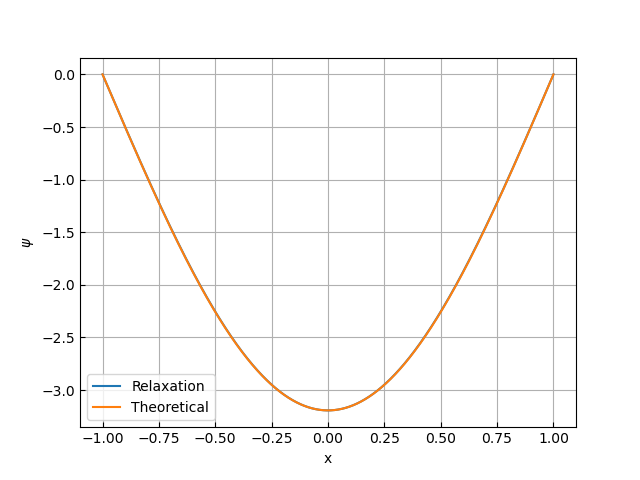

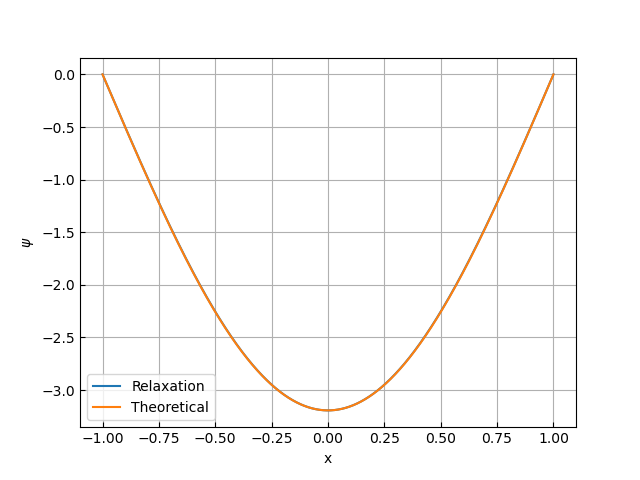

In [3]:
fig, ax = plt.subplots(nrows=1,ncols=1,dpi=100)
ax.plot(x,y[0],label='Relaxation')
ax.plot(x,y[0].min()*np.cos(x*np.pi/2),label='Theoretical')
ax.set_xlabel('x')
ax.set_ylabel(r'$\psi$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')
fig.show()

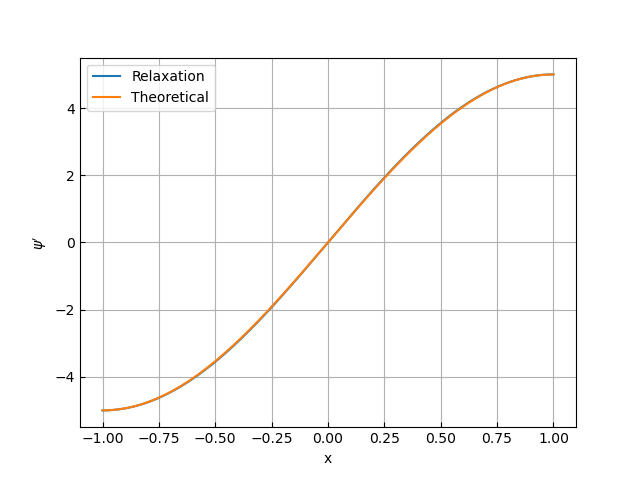

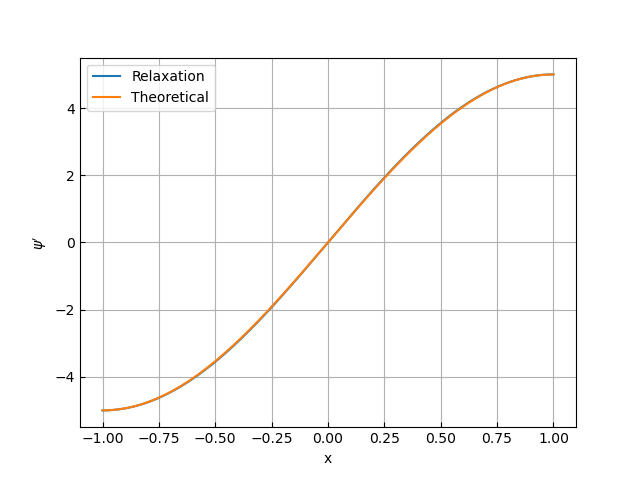

In [4]:
fig, ax = plt.subplots(nrows=1,ncols=1,dpi=100)
ax.plot(x,y[1],label='Relaxation')
ax.plot(x,y[1].max()*np.sin(x*np.pi/2),label='Theoretical')
ax.set_xlabel('x')
ax.set_ylabel(r'$\psi^{\prime}$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')
fig.show()

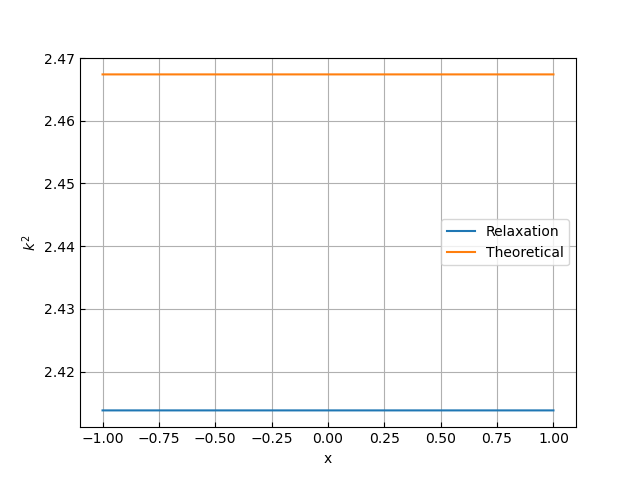

CPU times: user 50.7 ms, sys: 5.11 ms, total: 55.9 ms
Wall time: 273 ms


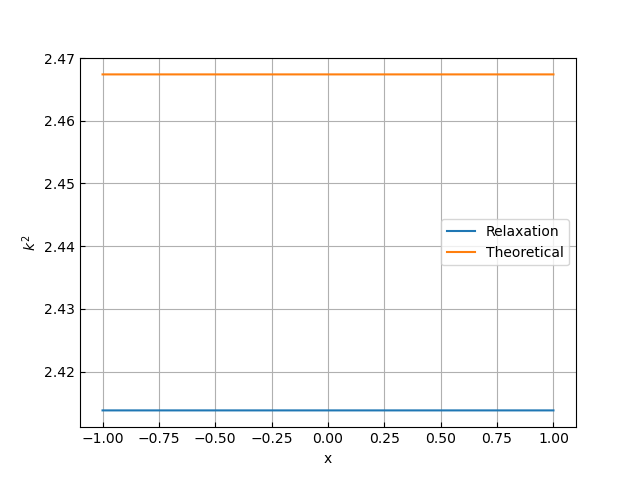

In [5]:
%%time
fig, ax = plt.subplots(nrows=1,ncols=1,dpi=100)
ax.plot(x,y[2],label='Relaxation')
ax.plot(x,(np.pi/2)**2*np.ones(mesh),label='Theoretical')
ax.set_xlabel('x')
ax.set_ylabel(r'$k^{2}$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')
fig.show()